In [259]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import torchmetrics
from torchmetrics import Metric
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
from torch.nn.utils.rnn import pad_sequence
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision.datasets import CocoDetection
import copy
import math
from PIL import Image
import cv2
import albumentations as A 
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
import sys
%matplotlib inline
print(torch.__version__)
print(torchvision.__version__)
from pycocotools.coco import COCO
from albumentations.pytorch import ToTensorV2
#import wandb
import matplotlib.patches as patches

#from google.colab import drive
#drive.mount('/content/drive')

2.2.1+cu121
0.17.1+cu121


# Hyperparamaters

In [260]:
# Hyperparameters
batch_size = 16
num_epochs= 1
lr = 0.001
image_size = [600, 600]
is_Test = False
wandb_on = False
device_cuda = True
if wandb_on:
    wandb.login()

    wandb.init(
        # set the wandb project where this run will be logged
        project="Bachelor0386",
        
        # track hyperparameters and run metadata
        config={
        "architecture": "Faster RCNN",
        "dataset": "CustomDataset",
        "epochs": 1,
        }
    )


In [261]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(image_size[0], image_size[1]), 
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(image_size[0], image_size[1]), 
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform


# Dataset class

In [262]:
class PotholeDetectionClass(datasets.VisionDataset):
    def __init__(self, root, stage='/train', transform=None, target_transform=None, transforms=None, batch_size = batch_size):
        super().__init__(root, transforms, transform, target_transform)
        self.stage = stage #train, valid, test
        self.coco = COCO(root + stage + "/_annotations.coco.json") # annotations stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
        self.batch_size = batch_size

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        path = "/" + path
        image = cv2.imread(self.root + self.stage + path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target]

        transformed = self.transforms(image=image, bboxes=boxes)
        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = []
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {}
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    
    def __len__(self):
        return len(self.ids)



In [263]:
dataset_path = "/Pothole_coco"
dataset_path = os.getcwd() + dataset_path

In [264]:
coco = COCO(dataset_path + "/train" + "/_annotations.coco.json")
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


{0: {'id': 0, 'name': 'potholes', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'pothole', 'supercategory': 'potholes'}}

In [265]:
classes = [i[1]['name'] for i in categories.items()]

In [266]:
train_dataset = PotholeDetectionClass(root=dataset_path, transforms=get_transforms(True))
test_dataset = PotholeDetectionClass(root=dataset_path, stage='/test', transforms=get_transforms(True))
valid_dataset = PotholeDetectionClass(root=dataset_path, stage= "/valid", transform=get_transforms(True))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [267]:
model = models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

C:\Users\aksel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\aksel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [268]:
def custom_collate(batch):
    return tuple(zip(*batch))


In [269]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=7, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=7, collate_fn=custom_collate)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=7, collate_fn=custom_collate)

Run to test if training works

In [270]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets)

Set device to Cuda

In [271]:
if device_cuda:
    device = torch.device("cuda") # use GPU to train
else:
    device = "cpu"
model = model.to(device)

In [272]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

In [273]:
def plot_image(img_tensor, annotation,phase='train'):

    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data



    ax.imshow(img.permute(1, 2, 0))
    for idx,box in enumerate(annotation["boxes"]):


      if phase=='test':
        test=1
      else:
        test=annotation['scores'][idx] 
      if test>0.95 :
        xmin, ymin, xmax, ymax = box
        color=['r','g','b','r']
        classes=['no mask','Masked','Improper masking','No-mask']
        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=3,edgecolor=color[annotation['labels'][idx]],facecolor='none')
        ax.text(xmin, ymin, classes[annotation['labels'][idx]],color='black',bbox=dict(facecolor=color[annotation['labels'][idx]], alpha=0.8))
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

In [274]:
def accuracyMetric(preds,annotations):
    non_accurate=0
    accurate=0
    def csm(A,B,corr):
        if corr:
            B=B-B.mean(axis=1)[:,np.newaxis]
            A=A-A.mean(axis=1)[:,np.newaxis]
        num=np.dot(A,B.T)
        p1=np.sqrt(np.sum(A**2,axis=1))[:,np.newaxis]
        p2=np.sqrt(np.sum(B**2,axis=1))[np.newaxis,:]
        return 1-(num/(p1*p2))
    inds=torch.where((preds['scores'])>0.91)
    distMatrix=csm(np.array(preds['boxes'][inds].cpu()),np.array(annotations['boxes'].cpu()),True)

    for i in range (distMatrix.shape[0]):
        cla=np.argmin(distMatrix[i,:])

        if preds['labels'][i]%3==annotations['labels'][cla]:
            accurate+=1
        else:
            non_accurate+=1
    allSamp=np.max(((accurate+non_accurate),len(annotations['labels'])))
    return (accurate/allSamp)

# Neural Network Class

In [275]:
class NN(pl.LightningModule):
    def __init__(self, model, optimizer, train_loader, test_loader):
        super().__init__()
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.losses_dict = []
        self.loss = nn.HingeEmbeddingLoss()

        self.save_hyperparameters()

    def forward(self, x,annotations=None,phase='train'):
        
        if phase=='train':
            
            out=self.model(x,annotations)
        else:
            self.model.eval()
            out=model(x)
        # no activation and no softmax at the end
        return out

    def training_step(self, batch, batch_idx):
        imgs, annotations = batch
        imgs = list(img for img in imgs)
        annotations = [{k: v for k, v in t.items()} for t in annotations]
        

        # Forward pass
        loss_dict = self(imgs,annotations)
        losses = sum(loss for loss in loss_dict.values())
        if wandb_on:
            wandb.log({"train/loss": losses})
        occurrences = np.count_nonzero(annotations[0]['labels'].cpu() == 2)
        occurrences2=np.count_nonzero(annotations[0]['labels'].cpu() == 1)
        occurrences=occurrences/(occurrences2+1 )

        if occurrences>=1:

            occurrences=np.clip(occurrences,1,4)
            loss_dict['loss_classifier']=occurrences*4*loss_dict['loss_classifier']
            print(f'Weighted {occurrences}')

        elif losses<0.2:
            for k,v in zip(loss_dict,loss_dict.values()):
                loss_dict[k]=v*0
        loss = sum(loss for loss in loss_dict.values())
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        tensorboard_logs = {'train_loss': loss , 'classifier_loss': loss_dict['loss_classifier'],
                            'box_reg_loss':loss_dict['loss_box_reg']}
        # use key 'log'

        return {"loss": loss, 'log': tensorboard_logs}


    def test_step(self, batch, batch_idx):
        imgs, annotations = batch
        print("#############################")
        type(annotations)
        print(annotations)
        type(imgs)
        print(imgs)

        # # Convert annotations tuple to a list of dictionaries
        # annotations = [{k: v for k, v in annotation.items()} for annotation in annotations]
        
        # # Perform inference
        # preds = self(list([imgs]), phase='test')
        
        # # Plot images with predictions and annotations
        # plot_image(imgs, preds[0])
        # for annotation in annotations:
        #     plot_image(imgs, annotation, phase='test')
        # if wandb_on:
        #     wandb.log({"test/accuracy": accuracyMetric(preds[0], annotations[0])},)
        # print((accuracyMetric(preds[0], annotations[0])))
                
        # Perform inference
        with torch.no_grad():
            preds = self(imgs, phase='test')

        # Compute any evaluation metrics using the predictions and annotations
        
        # For example, compute accuracy metric
        accuracy = accuracyMetric(preds, annotations)

        # Log the accuracy metric
        self.log('test_accuracy', accuracy, on_step=False, on_epoch=True, prog_bar=True)

        # Optionally, return any relevant output (e.g., predictions) to be aggregated by test_epoch_end
        return {"predictions": preds, "annotations": annotations}

    def configure_optimizers(self):
        return self.optimizer

    def train_dataloader(self):
        return self.train_loader

    def test_dataloader(self):
        return self.test_loader

    def load_from_checkpoint(cls, checkpoint_path, model, optimizer, train_loader, test_loader):
        model = model.load_from_checkpoint(checkpoint_path)
        return cls(model, optimizer, train_loader, test_loader)

    

In [276]:
#for epoch in range(num_epochs):
#    train_one_epoch(model, optimizer, train_loader, device, epoch)

lightning_module = NN(model, optimizer, train_loader, test_loader)
# Initialize a Lightning Trainer
if wandb_on:
    wandb_logger = WandbLogger(project='Bachelor', job_type='train')
    wandb_logger.watch(model, log="all")
    trainer = pl.Trainer(max_epochs=num_epochs,logger=wandb_logger)  # You can adjust the Trainer options
else:
    trainer = pl.Trainer(max_epochs=num_epochs)
# Start training


trainer.fit(lightning_module, train_loader)
trainer.test(lightning_module, test_loader)

if wandb_on:
    wandb.finish()

C:\Users\aksel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type               | Params
---------------------------------------------
0 | model | FasterRCNN         | 18.9 M
1 | loss  | HingeEmbeddingLoss | 0     
---------------------------------------------
18.9 M    Trainable params
58.9 K    Non-trainable params
18.9 M    Total params
75.721    Total estimated model params size (MB)


Testing DataLoader 0:   0%|          | 0/5 [20:50<?, ?it/s]


C:\Users\aksel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\aksel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\loops\fit_loop.py:293: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 30/30 [00:51<00:00,  0.59it/s, v_num=65, train_loss_step=0.459, train_loss_epoch=0.559]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 30/30 [00:53<00:00,  0.56it/s, v_num=65, train_loss_step=0.459, train_loss_epoch=0.559]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\aksel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0:   0%|          | 0/5 [00:00<?, ?it/s]#############################
({'boxes': tensor([[  8.1081, 352.0000, 452.4324, 566.0000]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'image_id': tensor([0], device='cuda:0'), 'area': tensor([95085.4062], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 68.4211,   2.0000, 573.6842, 522.0000]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'image_id': tensor([1], device='cuda:0'), 'area': tensor([262736.8438], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[ 51.6556, 188.0000, 448.0132, 596.0000]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'image_id': tensor([2], device='cuda:0'), 'area': tensor([161713.9062], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}, {'boxes': tensor([[303.0216, 416.0000, 459.2806, 576.0000]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'image_id': tensor([3], device='cuda:0'

TypeError: list indices must be integers or slices, not str

In [ ]:
if wandb_on:
    class ImagePredictionLogger(pl.callbacks.Callback):
        def __init__(self, val_samples, num_samples=32):
            super().__init__()
            self.num_samples = num_samples
            self.val_imgs, self.val_labels = val_samples
            
        def on_validation_epoch_end(self, trainer, pl_module):
            val_imgs = self.val_imgs.to(device=pl_module.device)

            logits = pl_module(val_imgs)
            preds = torch.argmax(logits, -1)
            
            trainer.logger.experiment.log({
                "examples":[wandb.Image(x, caption=f"Pred:{pred}, Target:{y}") for x, pred, y in zip(val_imgs[:self.num_samples], preds, self.val_labels[:self.num_samples])]
            })

In [ ]:
#ckpt_path = "lightning_logs/version_10/checkpoints/epoch=0-step=30.ckpt"

#model = NN.load_from_checkpoint(checkpoint_path=ckpt_path, model=model, optimizer=optimizer, train_loader=train_loader, test_loader=test_loader, cls=NN)
#model.optimizers()
#trainer.fit(model)



#torch.cuda.empty_cache()

In [ ]:
test_dataset[8]

(tensor([[[0.5608, 0.5490, 0.5412,  ..., 0.6784, 0.6784, 0.6784],
          [0.5647, 0.5529, 0.5451,  ..., 0.6824, 0.6863, 0.6863],
          [0.5725, 0.5608, 0.5529,  ..., 0.6941, 0.6980, 0.6980],
          ...,
          [0.8667, 0.8549, 0.8353,  ..., 0.8078, 0.8314, 0.8314],
          [0.8471, 0.8275, 0.8078,  ..., 0.8275, 0.8471, 0.8471],
          [0.8353, 0.8157, 0.7922,  ..., 0.8353, 0.8549, 0.8549]],
 
         [[0.5529, 0.5412, 0.5333,  ..., 0.6902, 0.6902, 0.6902],
          [0.5569, 0.5451, 0.5373,  ..., 0.6941, 0.6980, 0.6980],
          [0.5647, 0.5529, 0.5451,  ..., 0.7059, 0.7098, 0.7098],
          ...,
          [0.8784, 0.8667, 0.8471,  ..., 0.8000, 0.8235, 0.8235],
          [0.8588, 0.8392, 0.8196,  ..., 0.8196, 0.8392, 0.8392],
          [0.8471, 0.8275, 0.8039,  ..., 0.8314, 0.8471, 0.8471]],
 
         [[0.5725, 0.5608, 0.5529,  ..., 0.7098, 0.7098, 0.7098],
          [0.5765, 0.5647, 0.5569,  ..., 0.7137, 0.7176, 0.7176],
          [0.5843, 0.5725, 0.5647,  ...,

In [ ]:
model.eval()
torch.cuda.empty_cache()


test_dataset = PotholeDetectionClass(root=dataset_path, stage="/test", transforms=get_transforms(False))



loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


C:\Users\aksel\AppData\Local\Temp\ipykernel_3708\2519280026.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_int = torch.tensor(img*255, dtype=torch.uint8)


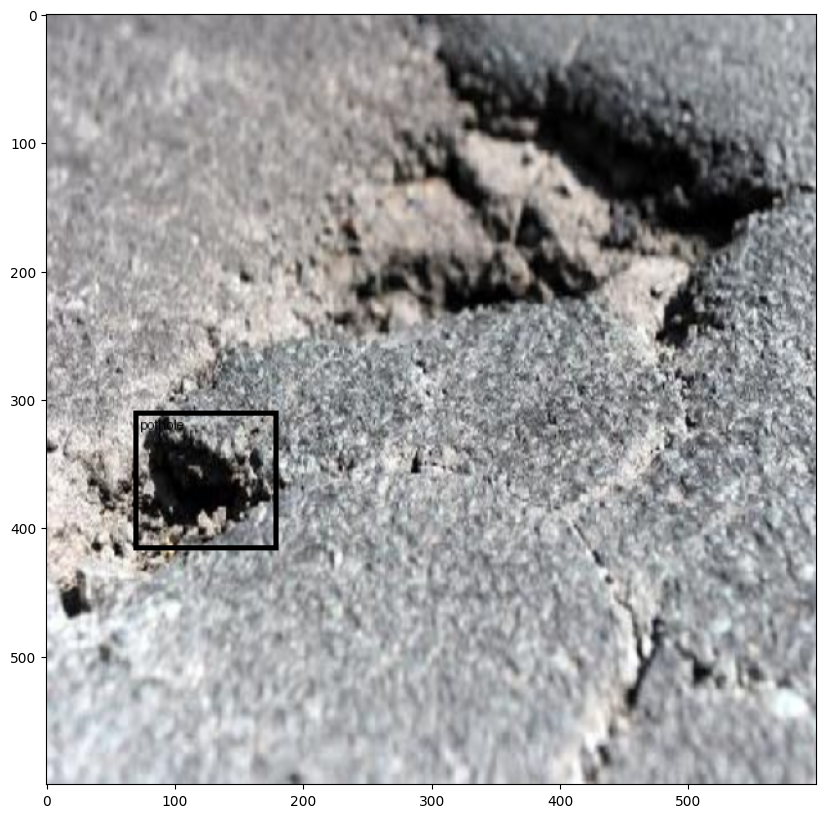

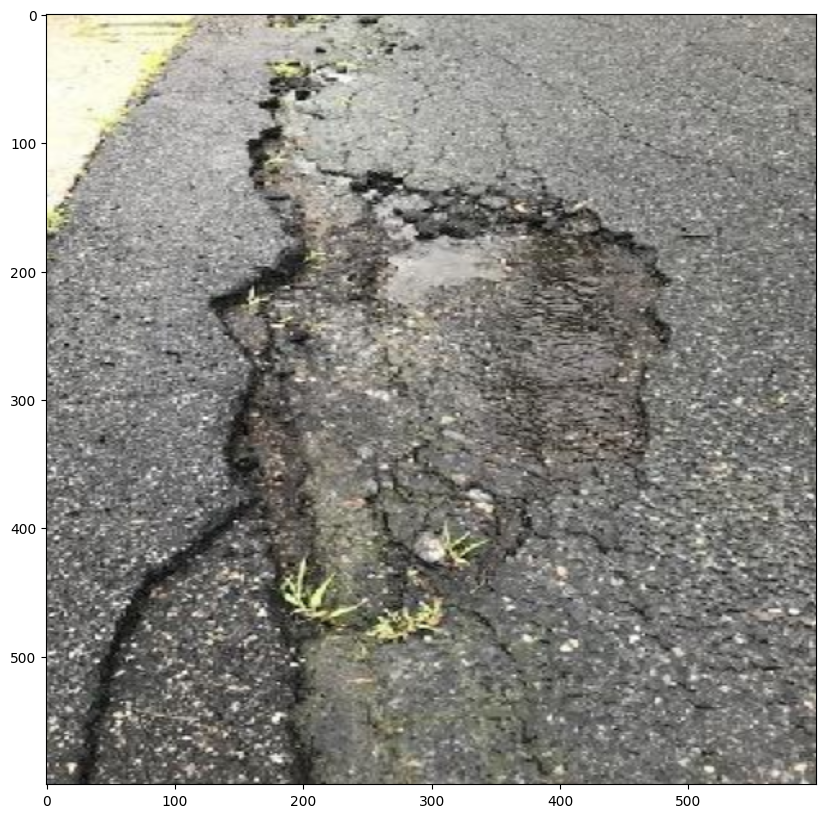

In [ ]:

device = "cpu"
for i in range(8,10): #test_dataset.__len__()-30
    img, _ = test_dataset[i]
    img_int = torch.tensor(img*255, dtype=torch.uint8)
    with torch.no_grad():
        prediction = model([img.to(device)])
        pred = prediction[0]
        fig = plt.figure(figsize=(14, 10))
    plt.imshow(draw_bounding_boxes(img_int,
        pred['boxes'][pred['scores'] > 0.8],
        [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
    ).permute(1, 2, 0))
